Total training points: 120
Points per task: N1=40, N2=50, N3=30
Start Training...
Epoch 000 | NLL: 390.8768
Epoch 020 | NLL: 24.9749
Epoch 040 | NLL: 10.4491
Epoch 060 | NLL: 6.7804
Epoch 040 | NLL: 10.4491
Epoch 060 | NLL: 6.7804
Epoch 080 | NLL: 5.2784
Epoch 100 | NLL: 4.6857
Epoch 080 | NLL: 5.2784
Epoch 100 | NLL: 4.6857
Epoch 120 | NLL: 4.4973
Epoch 140 | NLL: 4.4333
Epoch 120 | NLL: 4.4973
Epoch 140 | NLL: 4.4333
Epoch 160 | NLL: 4.4032
Epoch 180 | NLL: 4.3854
Epoch 160 | NLL: 4.4032
Epoch 180 | NLL: 4.3854
Epoch 200 | NLL: 4.3737
Epoch 220 | NLL: 4.3651
Epoch 200 | NLL: 4.3737
Epoch 220 | NLL: 4.3651
Epoch 240 | NLL: 4.3584
Epoch 260 | NLL: 4.3524
Epoch 240 | NLL: 4.3584
Epoch 260 | NLL: 4.3524
Epoch 280 | NLL: 4.3469

Training Complete.
------------------------------
Final Lengthscales of Latents:
tensor([1.0619, 0.9461, 1.0619, 2.6876, 1.2483, 0.9465, 0.9631, 0.9703, 0.9428,
        0.9474])

Final Scales (Magnitude) of Outputs:
tensor([0.7407, 1.3445, 0.6666])

Learned Mixing

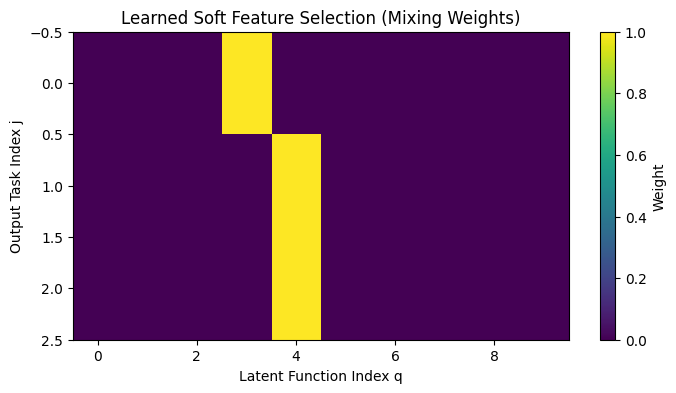

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# =============================================================================
# 1. Optimizer: Our Method (Explicit Euclidean Gradient on Simplex)
# =============================================================================
class SimplexSGD(optim.Optimizer):
    """
    期待値パラメータのユークリッド勾配を明示的に利用するオプティマイザ。
    (ユーザー提供コード)
    """
    def __init__(self, params, lr=0.1, line_search=False, ls_max_iter=10, ls_beta=0.5, ls_c1=1e-4):
        defaults = dict(lr=lr, line_search=line_search, ls_max_iter=ls_max_iter, 
                       ls_beta=ls_beta, ls_c1=ls_c1)
        super(SimplexSGD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            line_search = group['line_search']
            
            for p in group['params']:
                if p.grad is None: 
                    continue
                
                # w (Expectation Param)
                w = torch.softmax(p, dim=0)
                
                # dL/dtheta
                d_theta = p.grad
                
                # dL/dw = dL/dtheta / w (Explicit Euclidean Gradient)
                eps = 1e-12
                d_w = d_theta / (w + eps)
                
                # Center the gradient (remove drift in theta space)
                d_w = d_w - d_w.mean()
                
                # Store gradient direction for line search
                search_dir = -d_w
                
                # Line search
                if line_search and closure is not None:
                    alpha = self._line_search(p, search_dir, closure, group, loss)
                else:
                    alpha = lr
                
                # Update: Move in the direction of negative natural gradient
                p.add_(alpha * search_dir)
                
        return loss
    
    def _line_search(self, param, direction, closure, group, current_loss):
        alpha = group['lr']
        beta = group['ls_beta']
        c1 = group['ls_c1']
        max_iter = group['ls_max_iter']
        
        param_orig = param.clone()
        grad_dot_dir = (param.grad * direction).sum()
        
        if grad_dot_dir >= 0:
            return alpha * 0.1
        
        for i in range(max_iter):
            param.copy_(param_orig + alpha * direction)
            with torch.enable_grad():
                new_loss = closure()
            
            if new_loss.item() <= current_loss.item() + c1 * alpha * grad_dot_dir.item():
                param.copy_(param_orig)
                return alpha
            
            alpha *= beta
        
        param.copy_(param_orig)
        return alpha


# =============================================================================
# 2. Kernel Function (RBF)
# =============================================================================
def rbf_kernel(x1, x2, lengthscale, variance=1.0):
    """
    Computes RBF kernel matrix.
    x1: (N, D_in)
    x2: (M, D_in)
    lengthscale: scalar
    """
    # Euclidean distance squared
    dist_sq = torch.cdist(x1, x2, p=2)**2
    return variance * torch.exp(-0.5 * dist_sq / (lengthscale**2))


# =============================================================================
# 3. LMC Gaussian Process Model (Inhomogeneous Data Support)
# =============================================================================
class LMCGaussianProcess(nn.Module):
    """
    Linear Model of Coregionalization (LMC) GP with support for inhomogeneous data.
    
    Input format:
        X: (N_total, input_dim + 1) where the last column is the task indicator (0, 1, ..., D-1)
        y: (N_total,) flattened observations
    
    This allows each task to have different observation points.
    """
    def __init__(self, num_outputs, num_latents, input_dim=1):
        super().__init__()
        self.num_outputs = num_outputs
        self.num_latents = num_latents
        self.input_dim = input_dim
        
        # --- Hyperparameters (Optimized by Adam) ---
        # Latent functions parameters (different lengthscales -> LMC)
        self.log_lengthscales = nn.Parameter(torch.zeros(num_latents)) 
        
        # Scale parameters for each output (magnitude)
        # s_j in the formula: a_{j,q} = s_j * w_{j,q}
        self.log_scales = nn.Parameter(torch.zeros(num_outputs))
        
        # Observation noise (diagonal)
        self.log_noise_sigma = nn.Parameter(torch.tensor(-2.0))

        # --- Simplex Parameters (Optimized by SimplexSGD) ---
        # Mixing weights w_{j,q} s.t. sum_q w_{j,q} = 1
        # Shape: (num_outputs, num_latents)
        # Initialization: Nearly uniform but slightly random to break symmetry
        self.logits_W = nn.Parameter(torch.randn(num_outputs, num_latents) * 0.1)

    @property
    def lengthscales(self):
        return torch.exp(self.log_lengthscales)

    @property
    def scales(self):
        return torch.exp(self.log_scales)

    @property
    def noise_sigma(self):
        return torch.exp(self.log_noise_sigma)

    def get_mixing_weights(self):
        """
        Returns the normalized mixing weights W (on Simplex).
        """
        return torch.softmax(self.logits_W, dim=1)

    def get_coregionalization_matrices(self):
        """
        Computes the effective coregionalization matrix B for interpretation.
        A = diag(scales) @ W
        B = A @ A.T
        """
        W = self.get_mixing_weights()
        S = torch.diag(self.scales)
        A = S @ W
        return A @ A.T

    def _extract_x_and_task(self, X):
        """
        Splits input into spatial coordinates and task indicators.
        X: (N, input_dim + 1) where last column is task indicator
        Returns:
            x: (N, input_dim) spatial coordinates
            task_idx: (N,) integer task indices
        """
        x = X[:, :-1]  # All columns except last
        task_idx = X[:, -1].long()  # Last column as task indicator
        return x, task_idx

    def compute_kernel_inhomogeneous(self, X1, X2):
        """
        Computes the kernel matrix for inhomogeneous data.
        X1: (N1, input_dim + 1)
        X2: (N2, input_dim + 1)
        Returns: (N1, N2) kernel matrix
        """
        x1, task1 = self._extract_x_and_task(X1)
        x2, task2 = self._extract_x_and_task(X2)
        
        N1 = X1.shape[0]
        N2 = X2.shape[0]
        
        # Compute mixing matrix A = S * W
        W = self.get_mixing_weights()  # (D, Q)
        s = self.scales.view(-1, 1)    # (D, 1)
        A = s * W                      # (D, Q)

        
        
        # Initialize kernel matrix
        K = torch.zeros(N1, N2)
        
        ls = self.lengthscales
        
        for q in range(self.num_latents):
            # Compute latent kernel for this latent function
            dist_sq = torch.cdist(x1, x2, p=2)**2
            K_q = torch.exp(-0.5 * dist_sq / (ls[q]**2))  # (N1, N2)
            
            # Get mixing coefficients for each observation based on task
            # a1[i] = A[task1[i], q]
            a1 = A[task1, q]  # (N1,)
            a2 = A[task2, q]  # (N2,)
            
            # Outer product of mixing coefficients
            B_q = a1.unsqueeze(1) * a2.unsqueeze(0)  # (N1, N2)
            
            K += B_q * K_q
        
        return K

    def forward(self, X):
        """
        Computes the full kernel matrix K(X, X) + sigma^2 I for inhomogeneous data.
        X: (N_total, input_dim + 1) where last column is task indicator
        """
        K = self.compute_kernel_inhomogeneous(X, X)
        
        # Add noise
        noise_cov = self.noise_sigma**2 * torch.eye(K.shape[0])
        return K + noise_cov

    def negative_log_likelihood(self, X, y):
        """
        X: (N_total, input_dim + 1) with task indicators
        y: (N_total,) flattened observations
        """
        K = self.forward(X)
        
        # Exact GP Inference (Cholesky)
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(K.shape[0]))
        
        # alpha = K^{-1} y
        alpha = torch.cholesky_solve(y.unsqueeze(1), L)
        
        # NLL terms
        data_fit = 0.5 * y @ alpha.squeeze()
        complexity = torch.sum(torch.log(torch.diag(L)))
        const = 0.5 * len(y) * math.log(2 * math.pi)
        
        return data_fit + complexity + const


# =============================================================================
# 4. Data Preparation Utilities
# =============================================================================
def prepare_inhomogeneous_data(x_list, y_list):
    """
    Prepares inhomogeneous data for LMC model.
    
    Args:
        x_list: List of tensors, x_list[j] has shape (N_j, input_dim) for task j
        y_list: List of tensors, y_list[j] has shape (N_j,) for task j
    
    Returns:
        X: (N_total, input_dim + 1) with task indicators in last column
        y: (N_total,) flattened observations
    """
    X_parts = []
    y_parts = []
    
    for j, (x_j, y_j) in enumerate(zip(x_list, y_list)):
        N_j = x_j.shape[0]
        # Create task indicator column
        task_indicator = torch.full((N_j, 1), j, dtype=x_j.dtype)
        # Concatenate spatial coords with task indicator
        X_j = torch.cat([x_j, task_indicator], dim=1)
        X_parts.append(X_j)
        y_parts.append(y_j.flatten())
    
    X = torch.cat(X_parts, dim=0)
    y = torch.cat(y_parts, dim=0)
    
    return X, y


def prepare_homogeneous_data(x_train, y_train):
    """
    Converts homogeneous data format to inhomogeneous format for backward compatibility.
    
    Args:
        x_train: (N, input_dim) shared input points
        y_train: (N, num_outputs) observations for all tasks at same points
    
    Returns:
        X: (N * num_outputs, input_dim + 1)
        y: (N * num_outputs,)
    """
    N, D = y_train.shape
    x_list = [x_train for _ in range(D)]
    y_list = [y_train[:, j] for j in range(D)]
    return prepare_inhomogeneous_data(x_list, y_list)


# =============================================================================
# 5. Training Loop (Alternating Optimization)
# =============================================================================
def train_lmc(model, X_train, y_train, num_epochs=200):
    """
    Trains the LMC model.
    
    Args:
        model: LMCGaussianProcess instance
        X_train: (N_total, input_dim + 1) with task indicators
        y_train: (N_total,) flattened observations
        num_epochs: number of training epochs
    """
    # --- Split Parameters ---
    simplex_params = [model.logits_W]
    hyper_params = [p for n, p in model.named_parameters() if 'logits_W' not in n]
    
    # --- Optimizers ---
    # 1. Ordinary Gradient Descent (Adam) for Hyperparameters
    optimizer_hyper = optim.Adam(hyper_params, lr=0.01)
    
    # 2. SimplexSGD for Mixing Weights (Latent selection)
    optimizer_simplex = SimplexSGD(simplex_params, lr=1.0, line_search=True)
    
    loss_history = []
    
    print("Start Training...")
    for epoch in range(num_epochs):
        model.train()
        
        # --- Step 1: Update Hyperparameters (Adam) ---
        optimizer_hyper.zero_grad()
        loss = model.negative_log_likelihood(X_train, y_train)
        loss.backward()
        optimizer_hyper.step()
        
        # --- Step 2: Update Simplex Weights (SimplexSGD) ---
        def closure():
            optimizer_simplex.zero_grad()
            loss_val = model.negative_log_likelihood(X_train, y_train)
            loss_val.backward()
            return loss_val

        optimizer_simplex.zero_grad()
        loss_val = model.negative_log_likelihood(X_train, y_train)
        loss_val.backward()
        optimizer_simplex.step(closure)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | NLL: {loss.item():.4f}")
        
        loss_history.append(loss.item())

    return loss_history


# =============================================================================
# 6. Example Run (Inhomogeneous Data)
# =============================================================================
if __name__ == "__main__":
    torch.manual_seed(42)
    
    # --- Synthetic Data Generation (Inhomogeneous) ---
    # Different number of points for each task
    N1, N2, N3 = 40, 50, 30  # Different sample sizes per task
    D = 3
    
    # Different observation points for each task
    x1 = torch.linspace(0, 10, N1).unsqueeze(1)
    x2 = torch.linspace(1, 9, N2).unsqueeze(1)   # Shifted range
    x3 = torch.linspace(2, 12, N3).unsqueeze(1)  # Extended range
    
    # True latent functions
    def u1_func(x): return torch.sin(x * 0.5)
    def u2_func(x): return torch.cos(x * 1.5)
    
    # Outputs are mixtures of u1 and u2
    y1 = 1.0 * u1_func(x1) + 0.1 * u2_func(x1) + torch.randn(N1, 1) * 0.1
    y2 = 0.1 * u1_func(x2) + 1.0 * u2_func(x2) + torch.randn(N2, 1) * 0.1
    y3 = 0.5 * u1_func(x3) + 0.5 * u2_func(x3) + torch.randn(N3, 1) * 0.1
    
    # Prepare inhomogeneous data
    x_list = [x1, x2, x3]
    y_list = [y1.flatten(), y2.flatten(), y3.flatten()]
    X_train, y_train = prepare_inhomogeneous_data(x_list, y_list)
    
    print(f"Total training points: {X_train.shape[0]}")
    print(f"Points per task: N1={N1}, N2={N2}, N3={N3}")
    
    # --- Model Setup ---
    Q_model = 10 
    model = LMCGaussianProcess(num_outputs=D, num_latents=Q_model)
    
    # --- Train ---
    loss_hist = train_lmc(model, X_train, y_train, num_epochs=300)
    
    # --- Analysis ---
    print("\nTraining Complete.")
    print("-" * 30)
    
    with torch.no_grad():
        W = model.get_mixing_weights()
        S = model.scales
        LS = model.lengthscales
        
        print("Final Lengthscales of Latents:")
        print(LS)
        
        print("\nFinal Scales (Magnitude) of Outputs:")
        print(S)
        
        print("\nLearned Mixing Weights W (Softmax):")
        print("Rows: Outputs, Cols: Latents")
        print(W)
        
        print("\nRow Sums (should be 1.0):")
        print(W.sum(dim=1))
    
    # Plotting Weights
    plt.figure(figsize=(8, 4))
    plt.imshow(W.detach().numpy(), aspect='auto', cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Weight')
    plt.xlabel('Latent Function Index q')
    plt.ylabel('Output Task Index j')
    plt.title('Learned Soft Feature Selection (Mixing Weights)')
    plt.savefig('lmc_simplex_weights.png')
    plt.show()


Visualizing Predictions...


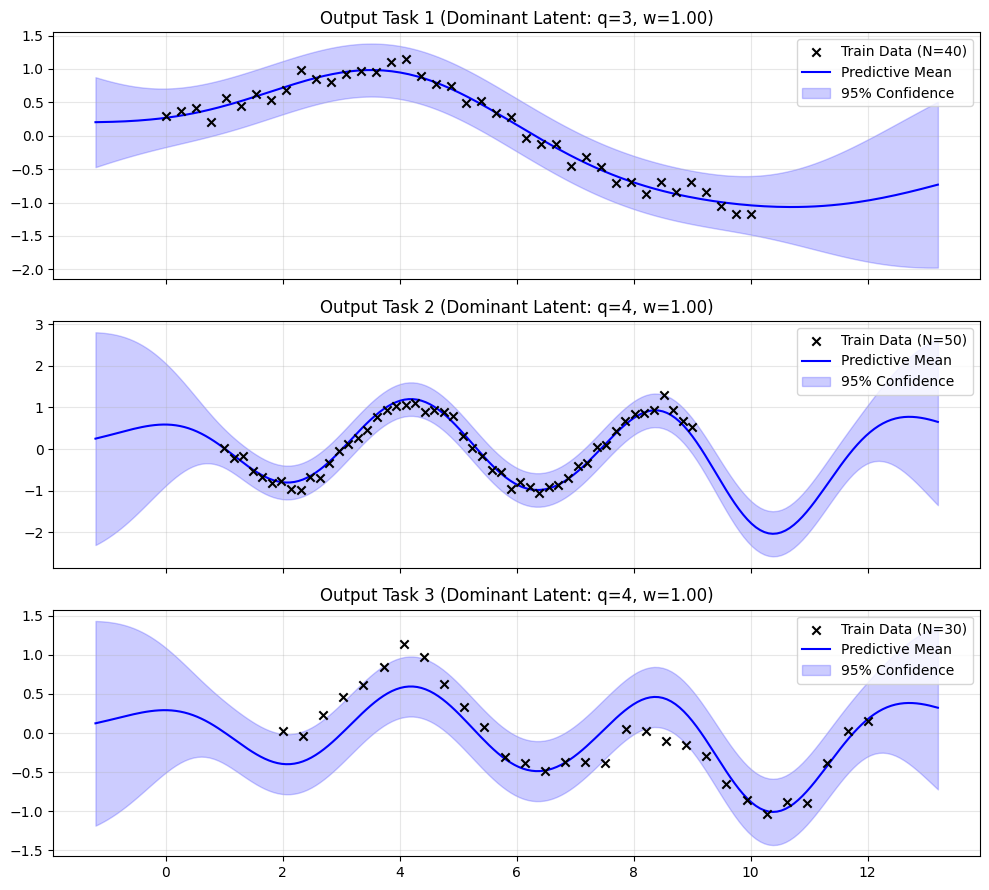

In [8]:
# =============================================================================
# 7. Prediction & Visualization Utils (Inhomogeneous Data)
# =============================================================================
def predict_lmc(model, X_train, y_train, x_test, task_idx):
    """
    Computes the posterior mean and variance for test points of a specific task.
    
    Args:
        model: trained LMCGaussianProcess
        X_train: (N_total, input_dim + 1) training data with task indicators
        y_train: (N_total,) training observations
        x_test: (M, input_dim) test input points (without task indicator)
        task_idx: integer, which task to predict (0, 1, ..., D-1)
    
    Returns:
        means: (M,) predictive means
        stds: (M,) predictive standard deviations
    """
    model.eval()
    with torch.no_grad():
        M = x_test.shape[0]
        
        # Create test inputs with task indicator
        task_indicator = torch.full((M, 1), task_idx, dtype=x_test.dtype)
        X_test = torch.cat([x_test, task_indicator], dim=1)
        
        # 1. Compute Kernel Matrices
        K_tt = model.forward(X_train)  # (N_total, N_total)
        L = torch.linalg.cholesky(K_tt + 1e-6 * torch.eye(K_tt.shape[0]))
        
        # K_test_train: (M, N_total)
        K_st = model.compute_kernel_inhomogeneous(X_test, X_train)
        
        # K_test_test: (M, M)
        K_ss = model.compute_kernel_inhomogeneous(X_test, X_test)
        
        # 2. Compute Mean
        alpha = torch.cholesky_solve(y_train.unsqueeze(1), L)
        mu = K_st @ alpha
        
        # 3. Compute Variance
        v_right = torch.linalg.solve_triangular(L, K_st.T, upper=False)
        cov_post = K_ss - v_right.T @ v_right
        
        # Extract diagonals + observation noise
        var = torch.diag(cov_post) + model.noise_sigma**2
        std = torch.sqrt(torch.clamp(var, min=1e-10))
        
        return mu.squeeze(), std


def visualize_predictions_inhomogeneous(model, X_train, y_train, x_list):
    """
    Plots the predictions for each output task with inhomogeneous data.
    
    Args:
        model: trained LMCGaussianProcess
        X_train: (N_total, input_dim + 1) training data with task indicators
        y_train: (N_total,) training observations
        x_list: list of tensors, original x coordinates per task
    """
    D = model.num_outputs
    
    # Determine global x range for test points
    all_x = torch.cat(x_list, dim=0)
    x_min, x_max = all_x.min().item(), all_x.max().item()
    padding = (x_max - x_min) * 0.1
    x_test = torch.linspace(x_min - padding, x_max + padding, 200).unsqueeze(1)
    
    # Reconstruct y values per task from flattened data
    # We need to track which points belong to which task
    task_indices = X_train[:, -1].long()
    
    fig, axes = plt.subplots(D, 1, figsize=(10, 3 * D), sharex=True)
    if D == 1: axes = [axes]
    
    x_test_np = x_test.numpy().flatten()
    
    for j in range(D):
        ax = axes[j]
        
        # Extract training data for this task
        mask = task_indices == j
        x_train_j = X_train[mask, :-1]  # Remove task indicator
        y_train_j = y_train[mask]
        
        # Predict for this task
        means, stds = predict_lmc(model, X_train, y_train, x_test, task_idx=j)
        
        # Plot training data
        ax.scatter(x_train_j.numpy().flatten(), y_train_j.numpy(), 
                   c='k', marker='x', label=f'Train Data (N={mask.sum().item()})', zorder=5)
        
        # Plot predictions
        mu = means.numpy()
        sigma = stds.numpy()
        
        ax.plot(x_test_np, mu, 'b-', label='Predictive Mean')
        ax.fill_between(x_test_np, mu - 2*sigma, mu + 2*sigma, 
                        color='b', alpha=0.2, label='95% Confidence')
        
        # Check active latents for this output
        with torch.no_grad():
            W = model.get_mixing_weights()
            top_latent = torch.argmax(W[j]).item()
            weight_val = W[j, top_latent].item()
            
        ax.set_title(f"Output Task {j+1} (Dominant Latent: q={top_latent}, w={weight_val:.2f})")
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.savefig('lmc_predictions.png')
    plt.show()


# Visualize the predictions
print("\nVisualizing Predictions...")
visualize_predictions_inhomogeneous(model, X_train, y_train, x_list)

Model Ranks per Latent: [3, 3, 3]
Start Training...
Epoch 000 | NLL: 64.3450
Epoch 020 | NLL: -36.7916
Epoch 020 | NLL: -36.7916
Epoch 040 | NLL: -44.9898
Epoch 040 | NLL: -44.9898
Epoch 060 | NLL: -48.3642
Epoch 060 | NLL: -48.3642
Epoch 080 | NLL: -50.8084
Epoch 080 | NLL: -50.8084
Epoch 100 | NLL: -52.8086
Epoch 100 | NLL: -52.8086
Epoch 120 | NLL: -54.3018
Epoch 120 | NLL: -54.3018
Epoch 140 | NLL: -55.0371
Epoch 140 | NLL: -55.0371
Epoch 160 | NLL: -55.2147
Epoch 160 | NLL: -55.2147
Epoch 180 | NLL: -55.2393
Epoch 180 | NLL: -55.2393
Epoch 200 | NLL: -55.2505
Epoch 200 | NLL: -55.2505
Epoch 220 | NLL: -55.2595
Epoch 220 | NLL: -55.2595
Epoch 240 | NLL: -55.2649
Epoch 240 | NLL: -55.2649
Epoch 260 | NLL: -55.2695
Epoch 260 | NLL: -55.2695
Epoch 280 | NLL: -55.2722
Epoch 280 | NLL: -55.2722

Training Complete.
------------------------------
Latent q=0 | Config Rank: 3 | Matrix Shape: torch.Size([3, 3]) | Computed Rank(B_q): 2
Latent q=1 | Config Rank: 3 | Matrix Shape: torch.Size([3

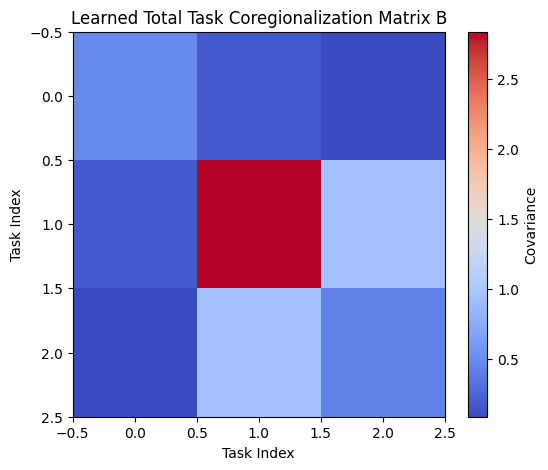

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# =============================================================================
# 1. Optimizer: Our Method (Explicit Euclidean Gradient on Simplex)
# =============================================================================
class SimplexSGD(optim.Optimizer):
    """
    (変更なし) 期待値パラメータのユークリッド勾配を明示的に利用するオプティマイザ。
    """
    def __init__(self, params, lr=0.1, line_search=False, ls_max_iter=10, ls_beta=0.5, ls_c1=1e-4):
        defaults = dict(lr=lr, line_search=line_search, ls_max_iter=ls_max_iter, 
                       ls_beta=ls_beta, ls_c1=ls_c1)
        super(SimplexSGD, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            line_search = group['line_search']
            
            for p in group['params']:
                if p.grad is None: 
                    continue
                
                # w (Expectation Param)
                # dim=0 でsoftmaxをとるため、(D, R) の行列であっても
                # 「各列(ランク成分)ごとに」和が1になる制約がかかる
                w = torch.softmax(p, dim=0)
                
                # dL/dtheta
                d_theta = p.grad
                
                # dL/dw
                eps = 1e-12
                d_w = d_theta / (w + eps)
                
                # Center the gradient
                d_w = d_w - d_w.mean(dim=0, keepdim=True) # dim=0方向の平均を引く
                
                # Store gradient direction for line search
                search_dir = -d_w
                
                # Line search
                if line_search and closure is not None:
                    alpha = self._line_search(p, search_dir, closure, group, loss)
                else:
                    alpha = lr
                
                # Update
                p.add_(alpha * search_dir)
                
        return loss
    
    def _line_search(self, param, direction, closure, group, current_loss):
        alpha = group['lr']
        beta = group['ls_beta']
        c1 = group['ls_c1']
        max_iter = group['ls_max_iter']
        
        param_orig = param.clone()
        grad_dot_dir = (param.grad * direction).sum()
        
        if grad_dot_dir >= 0:
            return alpha * 0.1
        
        for i in range(max_iter):
            param.copy_(param_orig + alpha * direction)
            with torch.enable_grad():
                new_loss = closure()
            
            if new_loss.item() <= current_loss.item() + c1 * alpha * grad_dot_dir.item():
                param.copy_(param_orig)
                return alpha
            
            alpha *= beta
        
        param.copy_(param_orig)
        return alpha


# =============================================================================
# 2. Kernel Function (RBF)
# =============================================================================
# (変更なし)

# =============================================================================
# 3. LMC Gaussian Process Model (Variable Rank Support)
# =============================================================================
class LMCGaussianProcess(nn.Module):
    """
    Linear Model of Coregionalization (LMC) with Variable Rank Support.
    """
    def __init__(self, num_outputs, num_latents, ranks=None, input_dim=1):
        """
        ranks: List of ints of length num_latents. 
               Specifies the rank of B_q for each latent q.
               If None, defaults to rank 1 for all q.
        """
        super().__init__()
        self.num_outputs = num_outputs
        self.num_latents = num_latents
        self.input_dim = input_dim
        
        # --- Handle Ranks ---
        if ranks is None:
            self.ranks = [1] * num_latents
        else:
            assert len(ranks) == num_latents, "ranks list must match num_latents"
            self.ranks = ranks
        
        # --- Hyperparameters ---
        self.log_lengthscales = nn.Parameter(torch.zeros(num_latents)) 
        self.log_scales = nn.Parameter(torch.zeros(num_outputs))
        self.log_noise_sigma = nn.Parameter(torch.tensor(-2.0))

        # --- Mixing Weights (Variable Rank) ---
        # 以前は1つの行列でしたが、今回は各qで形状(D, rank_q)が異なるため
        # ParameterList を使用して個別に保持します。
        self.logits_list = nn.ParameterList()
        
        for q in range(num_latents):
            r_q = self.ranks[q]
            # Shape: (D, r_q)
            # 初期化: 対称性を崩すためのランダム初期化
            param = nn.Parameter(torch.randn(num_outputs, r_q) * 0.1)
            self.logits_list.append(param)

    @property
    def lengthscales(self):
        return torch.exp(self.log_lengthscales)

    @property
    def scales(self):
        return torch.exp(self.log_scales)

    @property
    def noise_sigma(self):
        return torch.exp(self.log_noise_sigma)

    def get_mixing_matrix_for_q(self, q):
        """
        q番目の潜在関数に対する混合行列 W_q (D, rank_q) を返す
        """
        return torch.softmax(self.logits_list[q], dim=0)

    def get_coregionalization_matrices(self):
        """
        全タスク間の相関行列 B_total = sum_q B_q を計算して返す (可視化用)
        """
        B_total = torch.zeros(self.num_outputs, self.num_outputs)
        S = torch.diag(self.scales)
        
        for q in range(self.num_latents):
            W_q = self.get_mixing_matrix_for_q(q) # (D, r_q)
            A_q = S @ W_q                         # (D, r_q)
            B_q = A_q @ A_q.T                     # (D, D), Rank is at most r_q
            B_total += B_q
            
        return B_total

    def _extract_x_and_task(self, X):
        x = X[:, :-1]
        task_idx = X[:, -1].long()
        return x, task_idx

    def compute_kernel_inhomogeneous(self, X1, X2):
        """
        可変ランク対応版カーネル計算
        """
        x1, task1 = self._extract_x_and_task(X1)
        x2, task2 = self._extract_x_and_task(X2)
        
        N1 = X1.shape[0]
        N2 = X2.shape[0]
        
        # Scale parameters (D, 1)
        s = self.scales.view(-1, 1)
        
        # Initialize kernel matrix
        K = torch.zeros(N1, N2)
        ls = self.lengthscales
        
        for q in range(self.num_latents):
            # 1. 空間カーネル k_q(x, x')
            dist_sq = torch.cdist(x1, x2, p=2)**2
            K_q = torch.exp(-0.5 * dist_sq / (ls[q]**2))
            
            # 2. 混合行列 A_q = S * W_q の取得
            W_q = self.get_mixing_matrix_for_q(q) # (D, r_q)
            A_q = s * W_q                         # (D, r_q) ブロードキャスト
            
            # 3. データ点に対応する行ベクトルの抽出
            # task1, task2 はインデックスなので、それを使って行を抜き出す
            # A_obs1: (N1, r_q)
            # A_obs2: (N2, r_q)
            A_obs1 = A_q[task1] 
            A_obs2 = A_q[task2]
            
            # 4. コアリジョナライゼーション成分 B_q の計算
            # 以前は rank=1 だったのでベクトル外積でしたが、
            # 今回は (N1, r) @ (r, N2) の行列積になります
            B_q_block = A_obs1 @ A_obs2.T  # (N1, N2)
            
            # 加算
            K += B_q_block * K_q
        
        return K

    def forward(self, X):
        K = self.compute_kernel_inhomogeneous(X, X)
        noise_cov = self.noise_sigma**2 * torch.eye(K.shape[0])
        return K + noise_cov

    def negative_log_likelihood(self, X, y):
        K = self.forward(X)
        # Cholesky decomposition with jitter for stability
        L = torch.linalg.cholesky(K + 1e-5 * torch.eye(K.shape[0]))
        alpha = torch.cholesky_solve(y.unsqueeze(1), L)
        
        data_fit = 0.5 * y @ alpha.squeeze()
        complexity = torch.sum(torch.log(torch.diag(L)))
        const = 0.5 * len(y) * math.log(2 * math.pi)
        
        return data_fit + complexity + const

# =============================================================================
# 4. Data Preparation Utilities (変更なし)
# =============================================================================
def prepare_inhomogeneous_data(x_list, y_list):
    X_parts = []
    y_parts = []
    for j, (x_j, y_j) in enumerate(zip(x_list, y_list)):
        N_j = x_j.shape[0]
        task_indicator = torch.full((N_j, 1), j, dtype=x_j.dtype)
        X_j = torch.cat([x_j, task_indicator], dim=1)
        X_parts.append(X_j)
        y_parts.append(y_j.flatten())
    return torch.cat(X_parts, dim=0), torch.cat(y_parts, dim=0)

# =============================================================================
# 5. Training Loop (Updated for ParameterList)
# =============================================================================
def train_lmc(model, X_train, y_train, num_epochs=200):
    # --- Split Parameters ---
    # ParameterList内の全パラメータをSimplexSGDの対象にする
    simplex_params = list(model.logits_list.parameters())
    
    # それ以外(lengthscales, scales, noise)をAdamの対象にする
    hyper_params = [
        model.log_lengthscales, 
        model.log_scales, 
        model.log_noise_sigma
    ]
    
    # --- Optimizers ---
    optimizer_hyper = optim.Adam(hyper_params, lr=0.01)
    optimizer_simplex = SimplexSGD(simplex_params, lr=1.0, line_search=True)
    
    loss_history = []
    
    print("Start Training...")
    for epoch in range(num_epochs):
        model.train()
        
        # Step 1: Hyperparameters
        optimizer_hyper.zero_grad()
        loss = model.negative_log_likelihood(X_train, y_train)
        loss.backward()
        optimizer_hyper.step()
        
        # Step 2: Simplex Weights
        def closure():
            optimizer_simplex.zero_grad()
            loss_val = model.negative_log_likelihood(X_train, y_train)
            loss_val.backward()
            return loss_val

        optimizer_simplex.zero_grad()
        loss_val = model.negative_log_likelihood(X_train, y_train)
        loss_val.backward()
        optimizer_simplex.step(closure)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | NLL: {loss.item():.4f}")
        
        loss_history.append(loss.item())

    return loss_history

# =============================================================================
# 6. Example Run
# =============================================================================
if __name__ == "__main__":
    torch.manual_seed(42)
    
    # --- Data Generation ---
    N1, N2, N3 = 40, 50, 30
    D = 3
    
    x1 = torch.linspace(0, 10, N1).unsqueeze(1)
    x2 = torch.linspace(1, 9, N2).unsqueeze(1)
    x3 = torch.linspace(2, 12, N3).unsqueeze(1)
    
    # ターゲット: 複雑な相関を作るため少し混ぜ方を複雑にする
    def u1_func(x): return torch.sin(x * 0.5)
    def u2_func(x): return torch.cos(x * 1.5)
    
    y1 = 1.0 * u1_func(x1) + 0.1 * u2_func(x1) + torch.randn(N1, 1) * 0.1
    y2 = 0.1 * u1_func(x2) + 1.0 * u2_func(x2) + torch.randn(N2, 1) * 0.1
    y3 = 0.5 * u1_func(x3) + 0.5 * u2_func(x3) + torch.randn(N3, 1) * 0.1
    
    x_list = [x1, x2, x3]
    y_list = [y1.flatten(), y2.flatten(), y3.flatten()]
    X_train, y_train = prepare_inhomogeneous_data(x_list, y_list)
    
    # --- Model Setup with Variable Ranks ---
    num_latents = 3
    
    # ここでランクを指定！
    # q=0: rank 1
    # q=1: rank 2 (より複雑な相関を表現可能)
    # q=2: rank 1
    ranks_config = [3, 3, 3] 
    
    model = LMCGaussianProcess(num_outputs=D, num_latents=num_latents, ranks=ranks_config)
    
    print(f"Model Ranks per Latent: {model.ranks}")
    
    # --- Train ---
    loss_hist = train_lmc(model, X_train, y_train, num_epochs=300)
    
    # --- Check Ranks ---
    print("\nTraining Complete.")
    print("-" * 30)
    
    with torch.no_grad():
        S = torch.diag(model.scales)
        
        for q in range(num_latents):
            r_q = model.ranks[q]
            W_q = model.get_mixing_matrix_for_q(q) # (D, r_q)
            A_q = S @ W_q
            B_q = A_q @ A_q.T
            
            numeric_rank = torch.linalg.matrix_rank(B_q, tol=1e-4)
            print(f"Latent q={q} | Config Rank: {r_q} | Matrix Shape: {W_q.shape} | Computed Rank(B_q): {numeric_rank.item()}")

    # --- Visualization of Total Coregionalization ---
    B_total = model.get_coregionalization_matrices().detach().numpy()
    
    plt.figure(figsize=(6, 5))
    plt.imshow(B_total, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Covariance')
    plt.title('Learned Total Task Coregionalization Matrix B')
    plt.xlabel('Task Index')
    plt.ylabel('Task Index')
    plt.show()

Computing GP posterior...
Visualizing predictions per task...


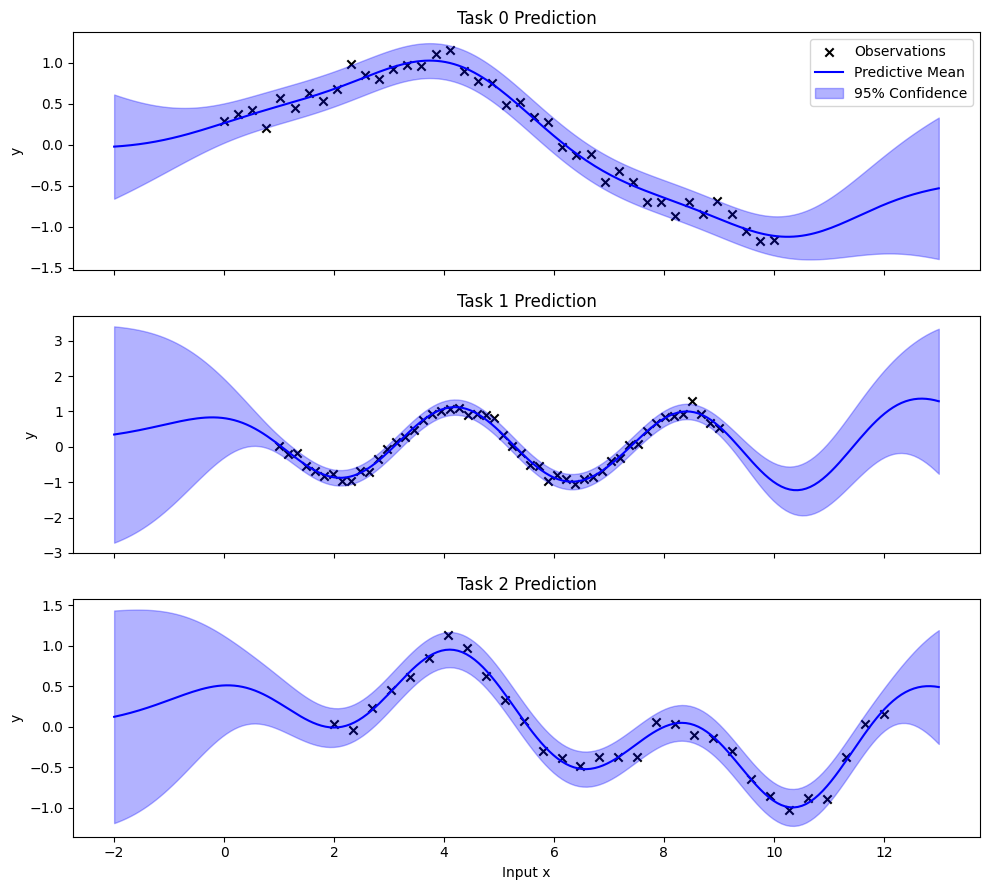


Visualizing Coregionalization Matrices (B_q)...


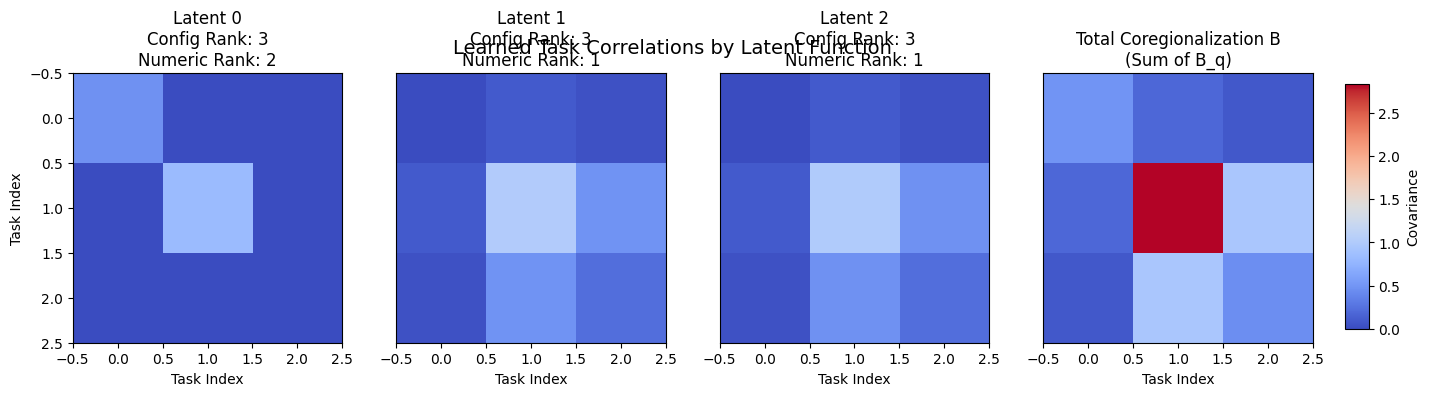

In [21]:
import matplotlib.pyplot as plt
import torch

def visualize_lmc_results(model, X_train, y_train, x_range=(-2, 13)):
    """
    LMCモデルの予測結果と、学習された相関構造を可視化する統合関数
    """
    model.eval()
    num_tasks = model.num_outputs
    num_latents = model.num_latents
    
    # ==========================================
    # 1. GP Posterior Prediction (Manual Calculation)
    # ==========================================
    # 事後分布の計算に必要な共通項 (K_inv * y) を先に計算
    print("Computing GP posterior...")
    with torch.no_grad():
        # K_train + noise
        K_ff = model.forward(X_train)
        L = torch.linalg.cholesky(K_ff + 1e-5 * torch.eye(K_ff.shape[0]))
        
        # alpha = K^{-1} y
        alpha = torch.cholesky_solve(y_train.unsqueeze(1), L)
        
    # テスト入力の作成
    n_test = 200
    x_test_linspace = torch.linspace(x_range[0], x_range[1], n_test).unsqueeze(1)
    
    # プロットの準備
    fig, axes = plt.subplots(num_tasks, 1, figsize=(10, 3 * num_tasks), sharex=True)
    if num_tasks == 1: axes = [axes]
    
    print("Visualizing predictions per task...")
    with torch.no_grad():
        for j in range(num_tasks):
            # --- Prepare Test Data for Task j ---
            task_idx = torch.full((n_test, 1), j)
            X_test_j = torch.cat([x_test_linspace, task_idx], dim=1)
            
            # --- Compute Kernels ---
            # k_star: test vs train (n_test, N_train)
            k_star = model.compute_kernel_inhomogeneous(X_test_j, X_train)
            
            # k_star_star: test vs test (diagonal only for variance)
            # 対角成分だけ欲しいが、実装上fullを計算して対角を取る
            k_star_star = model.compute_kernel_inhomogeneous(X_test_j, X_test_j)
            diag_k_star_star = torch.diagonal(k_star_star)
            
            # --- Posterior Mean & Variance ---
            # f_mean = k_star @ alpha
            f_mean = k_star @ alpha
            
            # f_var = k_ss - k_star @ K_inv @ k_star.T
            # v = L^{-1} k_star.T
            v = torch.linalg.solve_triangular(L, k_star.T, upper=False)
            f_var = diag_k_star_star - torch.sum(v**2, dim=0)
            
            # Add observation noise to variance for predictive interval
            pred_var = f_var + model.noise_sigma**2
            pred_std = torch.sqrt(pred_var)
            
            # --- Plotting ---
            ax = axes[j]
            
            # Plot Training Data (Extract points for task j)
            # X_trainの最後の列がタスクID
            mask = (X_train[:, -1] == j)
            train_x_j = X_train[mask, 0]
            train_y_j = y_train[mask]
            
            ax.scatter(train_x_j, train_y_j, c='black', marker='x', label='Observations')
            ax.plot(x_test_linspace.numpy(), f_mean.numpy(), 'b-', label='Predictive Mean')
            ax.fill_between(x_test_linspace.squeeze().numpy(), 
                            (f_mean.squeeze() - 2*pred_std).numpy(),
                            (f_mean.squeeze() + 2*pred_std).numpy(),
                            alpha=0.3, color='blue', label='95% Confidence')
            
            ax.set_title(f'Task {j} Prediction')
            ax.set_ylabel('y')
            if j == 0: ax.legend(loc='upper right')

    axes[-1].set_xlabel('Input x')
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 2. Coregionalization Matrix Visualization
    # ==========================================
    print("\nVisualizing Coregionalization Matrices (B_q)...")
    
    # プロット数: 各Latent q + Total
    fig, axes = plt.subplots(1, num_latents + 1, figsize=(4 * (num_latents + 1), 3.5))
    
    # 共通の最大値・最小値を取得してカラーバーを統一する
    with torch.no_grad():
        all_matrices = []
        S = torch.diag(model.scales)
        B_total = torch.zeros(num_tasks, num_tasks)
        
        for q in range(num_latents):
            W_q = model.get_mixing_matrix_for_q(q)
            A_q = S @ W_q
            B_q = A_q @ A_q.T
            all_matrices.append(B_q)
            B_total += B_q
            
        all_matrices.append(B_total)
        
        # カラーマップの範囲決定
        vmin = min([m.min().item() for m in all_matrices])
        vmax = max([m.max().item() for m in all_matrices])
        
        # --- Plot Indivisual B_q ---
        for q in range(num_latents):
            ax = axes[q]
            B_q = all_matrices[q]
            im = ax.imshow(B_q, cmap='coolwarm', vmin=vmin, vmax=vmax)
            
            rank_q = model.ranks[q]
            # 数値的ランクの計算
            num_rank = torch.linalg.matrix_rank(B_q, tol=1e-3).item()
            
            ax.set_title(f"Latent {q}\nConfig Rank: {rank_q}\nNumeric Rank: {num_rank}")
            ax.set_xlabel("Task Index")
            if q == 0: ax.set_ylabel("Task Index")
            else: ax.set_yticks([])

        # --- Plot Total B ---
        ax = axes[-1]
        im = ax.imshow(B_total, cmap='coolwarm', vmin=vmin, vmax=vmax)
        ax.set_title(f"Total Coregionalization B\n(Sum of B_q)")
        ax.set_xlabel("Task Index")
        ax.set_yticks([])
        
        # Colorbar
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        fig.colorbar(im, cax=cbar_ax, label='Covariance')
        
        plt.suptitle("Learned Task Correlations by Latent Function", fontsize=14)
        plt.show()

# --- 実行 ---
if __name__ == "__main__":
    # 上記のクラス定義や学習コードの後にこれを呼び出します
    visualize_lmc_results(model, X_train, y_train)